[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Fine-tune PaliGemma2 on Object Detection Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/README.md)
[![arXiv](https://img.shields.io/badge/arXiv-2412.03555-b31b1b.svg)](https://arxiv.org/abs/2412.03555)

PaliGemma 2 is built by combining the SigLIP-So400m vision encoder with the more recent and capable language models from the Gemma 2 family.

![PaliGemma2 Figure.1](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/paligemma2-1.png)

The authors use a 3-stage training approach similar to the original PaliGemma. In stage 1, they combine the pretrained vision and language model components and train them jointly on a multimodal task mixture. In stage 2, they train the models at higher resolutions of 448px^2 and 896px^2. In stage 3, they fine-tune the models on the target transfer tasks.

PaliGemma 2 models outperform the original PaliGemma at the same resolution and model size. Increasing the model size and resolution generally improves performance across a wide range of tasks, but the benefits differ depending on the task. Some tasks benefit more from increased resolution, while others benefit more from a larger language model.

![PaliGemma2 Figure.2](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/paligemma2-2.png)

Notebook requires A100 with 40GB of VRAM to train.

## Setup

### Configure your API keys

To fine-tune PaliGemma2, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Fri Dec  6 13:02:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

### Download dataset from Roboflow Universe

To fine-tune PaliGemma2, prepare your dataset in JSONL format. You can use Roboflow to easily convert any dataset into this format.

In [2]:
!pip install -q roboflow supervision peft bitsandbytes transformers==4.47.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 82.4 MB/s eta 0:00:00


In [3]:
from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("roboflow-jvuqo").project("poker-cards-fmjio")
version = project.version(4)
dataset = version.download("paligemma")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to poker-cards-4 in paligemma:: 100%|██████████| 905/905 [00:00<00:00, 5380.90it/s]


**NOTE:** Let's read the first few lines of the annotation file and examine the dataset format.

In [4]:
!head -n 5 {dataset.location}/dataset/_annotations.train.jsonl

{"image":"IMG_20220316_171834_jpg.rf.e47caf15cb1fbb80014a322084ebc1ec.jpg","prefix":"detect 10 of clubs ; 10 of diamonds ; 10 of hearts ; 10 of spades ; 2 of clubs ; 2 of diamonds ; 2 of hearts ; 2 of spades ; 3 of clubs ; 3 of diamonds ; 3 of hearts ; 3 of spades ; 4 of clubs ; 4 of diamonds ; 4 of hearts ; 4 of spades ; 5 of clubs ; 5 of diamonds ; 5 of hearts ; 5 of spades ; 6 of clubs ; 6 of diamonds ; 6 of hearts ; 6 of spades ; 7 of clubs ; 7 of diamonds ; 7 of hearts ; 7 of spades ; 8 of clubs ; 8 of diamonds ; 8 of hearts ; 8 of spades ; 9 of clubs ; 9 of diamonds ; 9 of hearts ; 9 of spades ; ace of clubs ; ace of diamonds ; ace of hearts ; ace of spades ; jack  of clubs ; jack of diamonds ; jack of hearts ; jack of spades ; king of clubs ; king of diamonds ; king of hearts ; king of spades ; queen of clubs ; queen of diamonds ; queen of hearts ; queen of spades","suffix":"<loc0401><loc0722><loc0702><loc1013> 5 of clubs ; <loc0214><loc0088><loc0529><loc0316> 6 of clubs ; <loc0

### Set up and test data loaders

In [5]:
import os
import json
import random
from PIL import Image
from torch.utils.data import Dataset


class JSONLDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self):
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx: int):
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        image = Image.open(image_path)
        return image, entry

In [6]:
train_dataset = JSONLDataset(
    jsonl_file_path=f"{dataset.location}/dataset/_annotations.train.jsonl",
    image_directory_path=f"{dataset.location}/dataset",
)
valid_dataset = JSONLDataset(
    jsonl_file_path=f"{dataset.location}/dataset/_annotations.valid.jsonl",
    image_directory_path=f"{dataset.location}/dataset",
)
test_dataset = JSONLDataset(
    jsonl_file_path=f"{dataset.location}/dataset/_annotations.test.jsonl",
    image_directory_path=f"{dataset.location}/dataset",
)

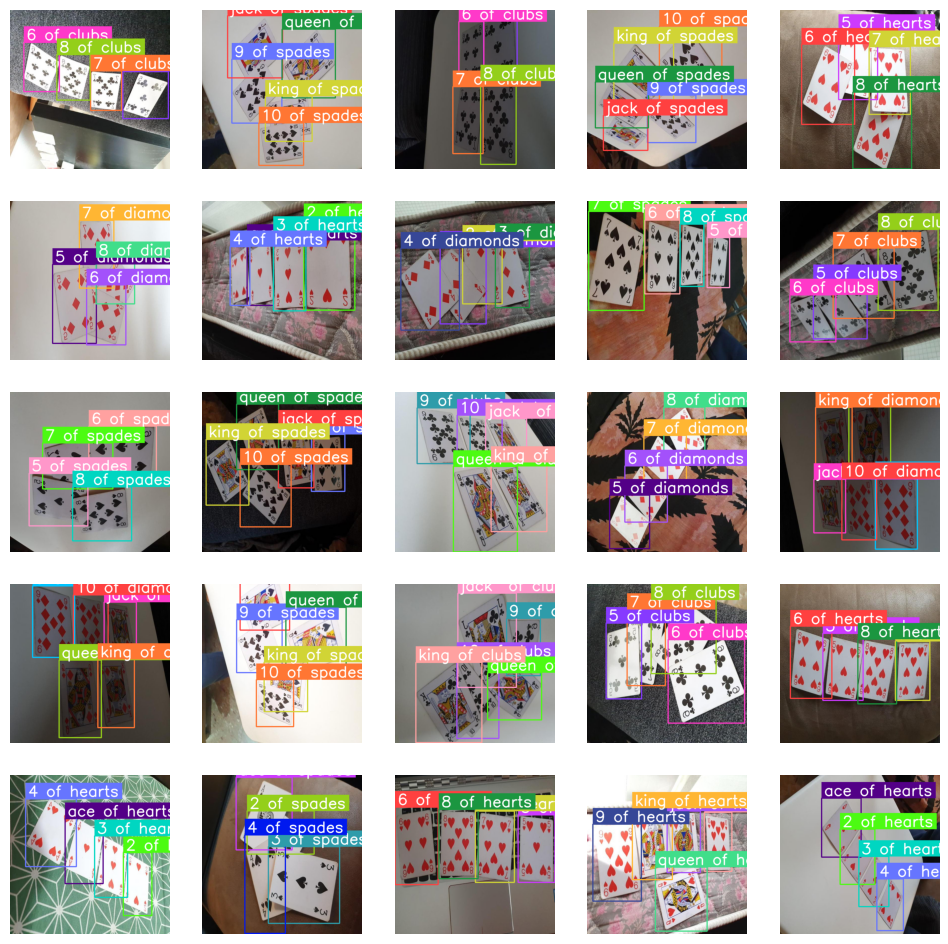

In [7]:
from tqdm import tqdm
import supervision as sv


CLASSES = train_dataset[0][1]['prefix'].replace("detect ", "").split(" ; ")

images = []
for i in range(25):
    image, label = train_dataset[i]
    detections = sv.Detections.from_lmm(
        lmm='paligemma',
        result=label["suffix"],
        resolution_wh=(image.width, image.height),
        classes=CLASSES)

    image = sv.BoxAnnotator(thickness=4).annotate(image, detections)
    image = sv.LabelAnnotator(text_scale=2, text_thickness=4).annotate(image, detections)
    images.append(image)

sv.plot_images_grid(images, (5, 5))

### Load PaliGemma2 model

**NOTE:** PaliGemma2 offers 9 pre-trained models with sizes of `3B`, `10B`, and `28B` parameters, and resolutions of `224`, `448`, and `896` pixels. In this tutorial, I'll be using the [`google/paligemma2-3b-pt-448`](https://huggingface.co/google/paligemma2-3b-pt-448) checkpoint. Resolution has a key impact on the mAP of the trained model, and it seems that `448` offers the most optimal balance between performance and compute resources required to train the model.

In [13]:
import torch
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration

MODEL_ID ="google/paligemma2-3b-pt-448"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
from huggingface_hub import notebook_login
notebook_login()

In [16]:
processor = PaliGemmaProcessor.from_pretrained(MODEL_ID)

preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

**NOTE:** Depending on the multimodal task you are trying to solve, we have prepared two training versions that optimize VRAM consumption.

- Freeze the image encoder and fine-tune only the text decoder.
- Fine-tune the entire model with LoRA and QLoRA.

In [17]:
# @title Freeze the image encoder


TORCH_DTYPE = torch.bfloat16

model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, torch_dtype=TORCH_DTYPE).to(DEVICE)

for param in model.vision_tower.parameters():
    param.requires_grad = False

for param in model.multi_modal_projector.parameters():
    param.requires_grad = False

config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/75.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [18]:
# @title Fine-tune the entire model with LoRA and QLoRA

# from transformers import BitsAndBytesConfig
# from peft import get_peft_model, LoraConfig

# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_compute_dtype=torch.bfloat16
# )

# lora_config = LoraConfig(
#     r=8,
#     target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
#     task_type="CAUSAL_LM",
# )

# model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, device_map="auto")
# model = get_peft_model(model, lora_config)
# model.print_trainable_parameters()

# TORCH_DTYPE = model.dtype

### Fine-tune PaliGemma2 on custom object detection dataset

In [19]:
from transformers import Trainer, TrainingArguments


def augment_suffix(suffix):
    parts = suffix.split(' ; ')
    random.shuffle(parts)
    return ' ; '.join(parts)


def collate_fn(batch):
    images, labels = zip(*batch)

    paths = [label["image"] for label in labels]
    prefixes = ["<image>" + label["prefix"] for label in labels]
    suffixes = [augment_suffix(label["suffix"]) for label in labels]

    inputs = processor(
        text=prefixes,
        images=images,
        return_tensors="pt",
        suffix=suffixes,
        padding="longest"
    ).to(TORCH_DTYPE).to(DEVICE)

    return inputs

args = TrainingArguments(
    num_train_epochs=16,
    remove_unused_columns=False,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    warmup_steps=2,
    learning_rate=2e-5,
    weight_decay=1e-6,
    adam_beta2=0.999,
    logging_steps=50,
    optim="adamw_hf",
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=1,
    output_dir="paligemma2_object_detection",
    bf16=True,
    report_to=["tensorboard"],
    dataloader_pin_memory=False
)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    args=args
)

In [20]:
trainer.train()

Step,Training Loss
50,1.891500
100,1.486100
150,1.346300
200,1.181200
250,0.991000
300,0.775400
350,0.575800
400,0.370100
450,0.257000
500,0.196400


TrainOutput(global_step=800, training_loss=0.6218061202764511, metrics={'train_runtime': 3875.2866, 'train_samples_per_second': 3.348, 'train_steps_per_second': 0.206, 'total_flos': 2.4515029351130976e+17, 'train_loss': 0.6218061202764511, 'epoch': 15.690505548705302})

### Run inference with fine-tuned PaliGemma2 model

The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


<loc0504><loc0430><loc0882><loc0815> 6 of clubs ; <loc0102><loc0482><loc0416><loc0840> 7 of clubs ; <loc0159><loc0180><loc0499><loc0486> 8 of clubs ; <loc0476><loc0102><loc0820><loc0424> 5 of clubs ; 


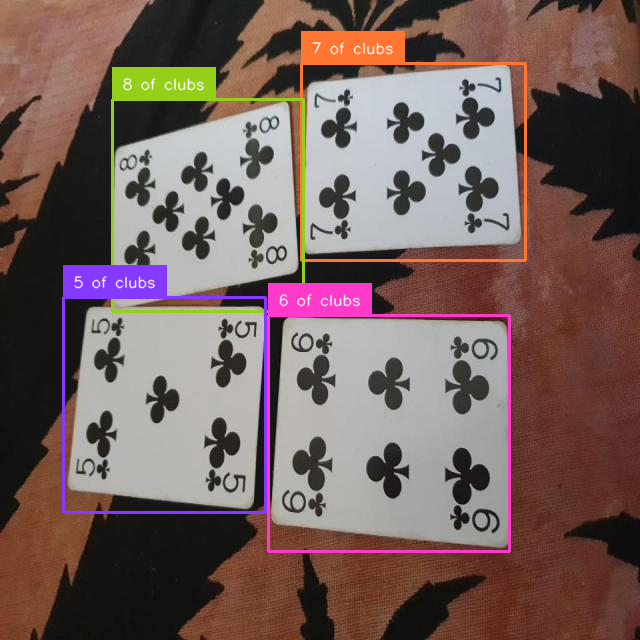

In [21]:
image, label = test_dataset[1]
prefix = "<image>" + label["prefix"]
suffix = label["suffix"]

inputs = processor(
    text=prefix,
    images=image,
    return_tensors="pt"
).to(TORCH_DTYPE).to(DEVICE)

prefix_length = inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**inputs, max_new_tokens=256, do_sample=False)
    generation = generation[0][prefix_length:]
    decoded = processor.decode(generation, skip_special_tokens=True)
    print(decoded)

w, h = image.size
detections = sv.Detections.from_lmm(
    lmm='paligemma',
    result=decoded,
    resolution_wh=(w, h),
    classes=CLASSES)

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator().annotate(annotated_image, detections)
annotated_image = sv.LabelAnnotator(smart_position=True).annotate(annotated_image, detections)
annotated_image

### Evaluate fine-tuned PaliGemma2 model

In [22]:
import numpy as np
from tqdm import tqdm

images = []
targets = []
predictions = []

with torch.inference_mode():
    for i in tqdm(range(len(test_dataset))):
        image, label = test_dataset[i]
        prefix = "<image>" + label["prefix"]
        suffix = label["suffix"]

        inputs = processor(
            text=prefix,
            images=image,
            return_tensors="pt"
        ).to(TORCH_DTYPE).to(DEVICE)

        prefix_length = inputs["input_ids"].shape[-1]

        generation = model.generate(**inputs, max_new_tokens=256, do_sample=False)
        generation = generation[0][prefix_length:]
        generated_text = processor.decode(generation, skip_special_tokens=True)

        w, h = image.size
        prediction = sv.Detections.from_lmm(
            lmm='paligemma',
            result=generated_text,
            resolution_wh=(w, h),
            classes=CLASSES)

        prediction.class_id = np.array([CLASSES.index(class_name) for class_name in prediction['class_name']])
        prediction.confidence = np.ones(len(prediction))

        target = sv.Detections.from_lmm(
            lmm='paligemma',
            result=suffix,
            resolution_wh=(w, h),
            classes=CLASSES)

        target.class_id = np.array([CLASSES.index(class_name) for class_name in target['class_name']])

        images.append(image)
        targets.append(target)
        predictions.append(prediction)

100%|██████████| 44/44 [04:59<00:00,  6.80s/it]


In [23]:
# @title Calculate mAP

from supervision.metrics import MeanAveragePrecision, MetricTarget

map_metric = MeanAveragePrecision(metric_target=MetricTarget.BOXES)
map_result = map_metric.update(predictions, targets).compute()

print(map_result)

MeanAveragePrecisionResult:
Metric target: MetricTarget.BOXES
Class agnostic: False
mAP @ 50:95: 0.6246
mAP @ 50:    0.7164
mAP @ 75:    0.6904
mAP scores: [0.7163872  0.71120399 0.69792334 0.69563849 0.69563849 0.69043413
 0.67398688 0.63946382 0.52168119 0.20399485]
IoU thresh: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
AP per class:
  0: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.60808581]
  1: [0.5049505  0.5049505  0.5049505  0.5049505  0.5049505  0.5049505
 0.5049505  0.5049505  0.5049505  0.25742574]
  2: [0.82791136 0.82791136 0.82791136 0.82791136 0.82791136 0.82791136
 0.82791136 0.82791136 0.24988213 0.0330033 ]
  3: [0.66336634 0.66336634 0.66336634 0.66336634 0.66336634 0.66336634
 0.66336634 0.66336634 0.66336634 0.16336634]
  4: [1.        1.        1.        1.        1.        1.        1.
 1.        1.        0.5049505]
  5: [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
  6: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  7: [0.8069306

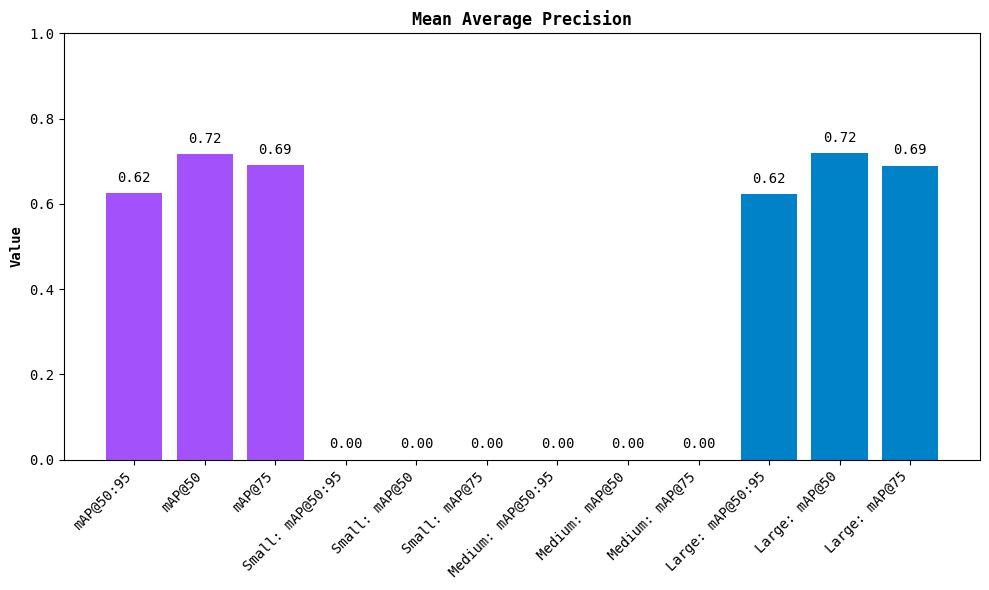

In [24]:
map_result.plot()

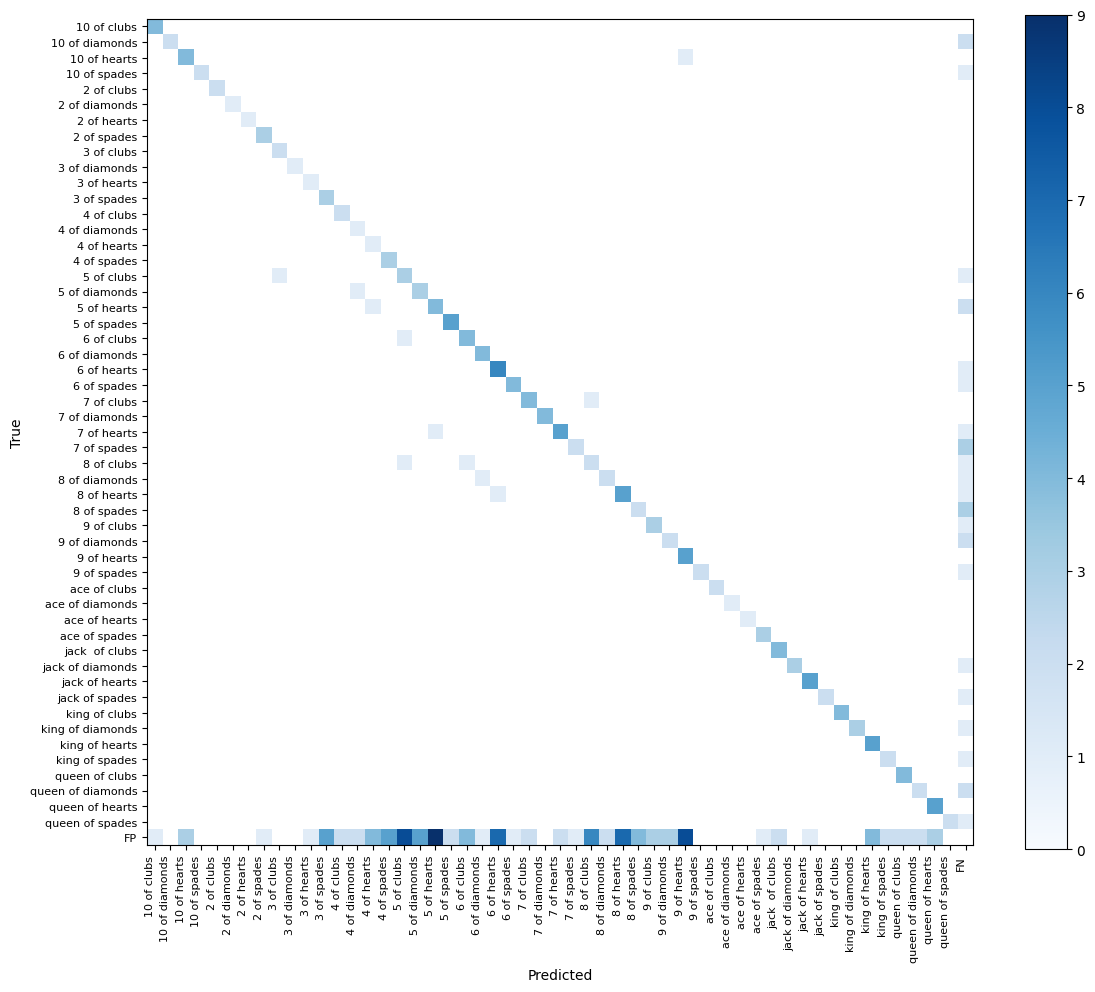

In [25]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot()

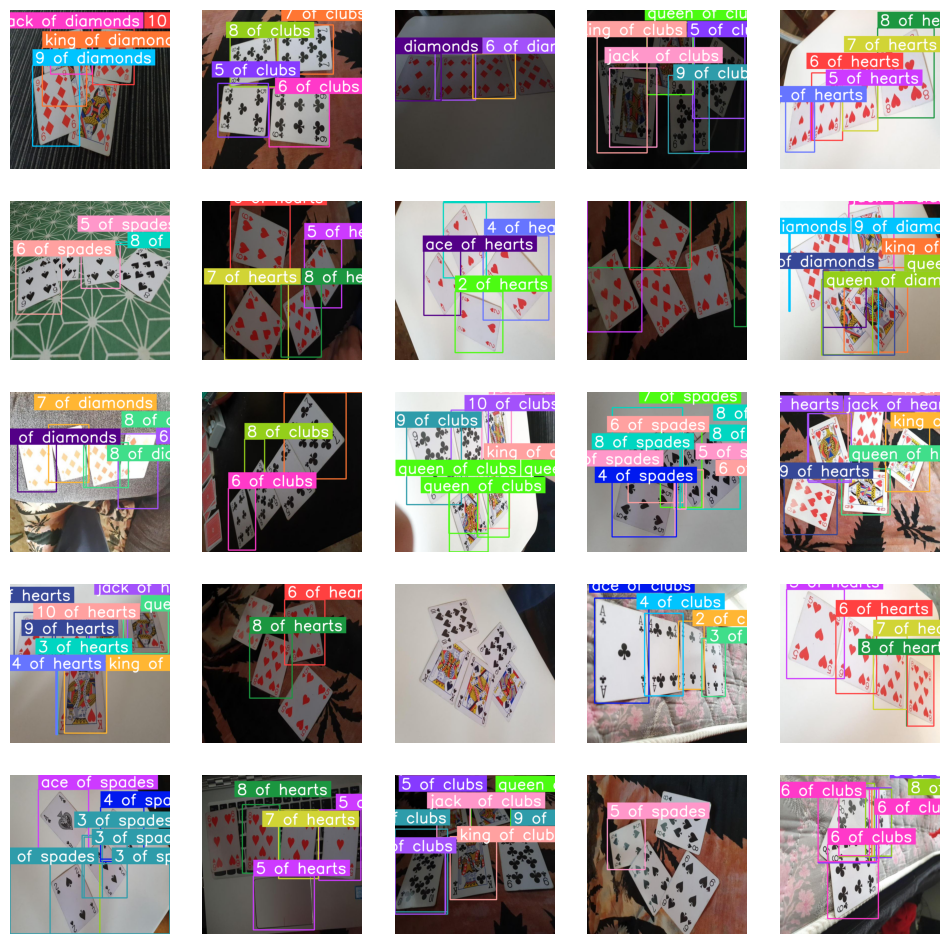

In [26]:
annotated_images = []

for i in range(25):
    image = images[i]
    detections = predictions[i]

    annotated_image = image.copy()
    annotated_image = sv.BoxAnnotator(thickness=4).annotate(annotated_image, detections)
    annotated_image = sv.LabelAnnotator(text_scale=2, text_thickness=4, smart_position=True).annotate(annotated_image, detections)
    annotated_images.append(annotated_image)

sv.plot_images_grid(annotated_images, (5, 5))